### Pre Processing the Data

Connecting to the Google Drive and referencing the neccessary path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#google drive project path
project_path = '/content/drive/MyDrive/DS/NLP_Final_Project/'

Mounted at /content/drive


### Importing the neccesary packages

In [ ]:

#Importing the neccessary packages
import pandas as pd
import numpy as np
import gc
import sys
import os
from multiprocessing import Pool
import time
import re
import string
from sklearn.model_selection import train_test_split
from sklearn import metrics
import psutil
import nltk
from nltk.corpus import stopwords
from unicodedata import category, name, normalize
import string
from wordcloud import WordCloud
from PIL import Image

nltk.download('stopwords')
from tqdm.notebook import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Embedding,GRU,LSTM,Bidirectional,GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Exporting User Defined Functions
sys.path.append(project_path + '/wordmapper/')
import mapping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creating Functions for Text Cleaning

In [ ]:
def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text


def remove_diacritics(s):
    return ''.join(c for c in normalize('NFKD', s.replace('ø', 'o').replace('Ø', 'O').replace('⁻', '-').replace('₋', '-'))
                  if category(c) != 'Mn')

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    # remove_diacritics don´t' ->  'don t'
    #text = remove_diacritics(text)
    return text

# clean numbers
def clean_number(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    text = re.sub(r'(\d+)(e)(\d+)','\g<1> \g<3>', text)
    return text

def pre_clean_rare_words(text):
    for rare_word in rare_words_mapping:
        if rare_word in text:
            text = text.replace(rare_word, rare_words_mapping[rare_word])

    return text

def clean_misspell(text):
    for bad_word in mispell_dict:
        if bad_word in text:
            text = text.replace(bad_word, mispell_dict[bad_word])
    return text

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_bad_case_words(text):
    for bad_word in bad_case_words:
        if bad_word in text:
            text = text.replace(bad_word, bad_case_words[bad_word])
    return text

def spacing_some_connect_words(text):
    """
    'Whyare' -> 'Why are'
    """
    ori = text
    for error in mis_spell_mapping:
        if error in text:
            text = text.replace(error, mis_spell_mapping[error])

    text = re.sub(r" (W|w)hat+(s)*[A|a]*(p)+ ", " WhatsApp ", text)
    text = re.sub(r" (W|w)hat\S ", " What ", text)
    text = re.sub(r" \S(W|w)hat ", " What ", text)
    text = re.sub(r" (W|w)hy\S ", " Why ", text)
    text = re.sub(r" \S(W|w)hy ", " Why ", text)
    text = re.sub(r" (H|h)ow\S ", " How ", text)
    text = re.sub(r" \S(H|h)ow ", " How ", text)
    text = re.sub(r" (W|w)hich\S ", " Which ", text)
    text = re.sub(r" \S(W|w)hich ", " Which ", text)
    text = re.sub(r" (W|w)here\S ", " Where ", text)
    text = re.sub(r" \S(W|w)here ", " Where ", text)
    text = mis_connect_re.sub(r" \1 ", text)
    text = text.replace("What sApp", ' WhatsApp ')
    text = remove_space(text)

    return text

# clean repeated letters
def clean_repeat_words(text):

    text = re.sub(r"\b(I|i)(I|i)+ng\b", "ing", text) #this one is causing few issues(fixed via monkey patching in other dicts for now), need to check it..
    text = re.sub(r"(-+|\.+)", " ", text)
    return text

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

def correct_spelling(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

def preprocess(text):
    """
    preprocess text main steps
    """
    text = remove_space(text)
    text = clean_special_punctuations(text)
    text = clean_number(text)
    text = pre_clean_rare_words(text)
    text = clean_misspell(text)
    text = spacing_punctuation(text)
    text = spacing_some_connect_words(text)
    text = clean_bad_case_words(text)
    text = clean_repeat_words(text)
    text = remove_space(text)
    return text

def text_clean_wrapper(df):
    df["Text_clean"] = df["Text"].progress_apply(preprocess)
    return df

def clean_text(x):

    x = str(x).replace(' s ','').replace('…', ' ').replace('—','-').replace('•°•°•','') #should be broken down to regexs (lazy to do it haha)
    for punct in "/-'":
        if punct in x:
            x = x.replace(punct, ' ')
    for punct in '&':
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    for punct in '?!-,"#$%\'()*+-/:;<=>@[\\]^_`{|}~–—✰«»§✈➤›☭✔½☺éïà😏🤣😢😁🙄😃😄😊😜😎😆💙👍🤔😅😡▀▄·―═►♥▬' + '“”’':
        #if we add . here then all the WEBPAGE LINKS WILL VANISH WE DON'T WANT THAT
        if punct in x: #can be used a FE for emojis but here we are just removing them..
            x = x.replace(punct, '')
    for punct in '.•': #hence here it is
        if punct in x:
            x = x.replace(punct, f' ')

    #can be improved more.....

    x = re.sub(r'[\x00-\x1f\x7f-\x9f\xad]', '', x)
    x = re.sub(r'(\d+)(e)(\d+)',r'\g<1> \g<3>', x) #is a dup from above cell...
    x = re.sub(r"(-+|\.+)\s?", "  ", x)
    x = re.sub("\s\s+", " ", x)
    x = re.sub(r'ᴵ+', '', x)

    x = re.sub(r'(can|by|been|and|are|for|it|TV|already|justhow|some|had|is|will|would|should|shall|must|can|his|here|there|them|these|their|has|have|the|be|that|not|was|he|just|they|who)(how)', '\g<1> \g<2>', x)
    #fixing words like hehow, therehow, hishow... (for some reason they are getting added, some flaw in preproceesing..)
    #the last regex ia a temp fix mainly and shouldn't be there

    return x

Specifying the variables for String Manipulation

In [ ]:
import mapping_1

In [ ]:
contraction_mapping = mapping_1.contraction_mapping
mispell_dict = mapping_1.mispell_dict
special_punc_mappings = mapping_1.special_punc_mappings
spaces = mapping_1.spaces
rare_words_mapping = mapping_1.rare_words_mapping
extra_punct = mapping_1.extra_punct
bad_case_words = mapping_1.bad_case_words


regular_punct = list(string.punctuation)
all_punct = list(set(regular_punct + extra_punct))

# do not spacing - and .
all_punct.remove('-')
all_punct.remove('.')


mis_connect_list = ['\b(W|w)hat\b', '\b(W|w)hy\b', '\b(H|h)ow\b', '\b(W|w)hich\b', '\b(W|w)here\b', '\b(W|w)ill\b']
mis_connect_re  = re.compile('(%s)' % '|'.join(mis_connect_list))

mis_spell_mapping = {'whattsup': 'WhatsApp', 'whatasapp':'WhatsApp', 'whatsupp':'WhatsApp',
                      'whatcus':'what cause', 'arewhatsapp': 'are WhatsApp', 'Hwhat':'what',
                      'Whwhat': 'What', 'whatshapp':'WhatsApp', 'howhat':'how that',
                      'Whybis':'Why is', 'laowhy86':'Foreigners who do not respect China',
                      'Whyco-education':'Why co-education',
                      "Howddo":"How do", 'Howeber':'However', 'Showh':'Show',
                      "Willowmagic":'Willow magic', 'WillsEye':'Will Eye', 'Williby':'will by',
                     'pretextt':'pre text','aɴᴅ':'and','amette':'annette','aᴛ':'at','Tridentinus':'mushroom',
                    'dailycaller':'daily caller', "™":'trade mark'}

stop = stopwords.words('english')


Creating Functions for Parallel Processing of Dataframe manipulation

In [ ]:
def df_parallelize_run(df, func):

    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    #df = sp.vstack(pool.map(func, df_split), format='csr') faster and mem efficient for
    pool.close()
    pool.join()

    return df

### Reading the data

In [ ]:
df1 = pd.read_csv(project_path + 'smileannotationsfinal.csv', header=None)
df2 = pd.read_csv(project_path +'Emotion_final/Emotion_final.csv')
df3_train = pd.read_csv(project_path +'archive/training.csv')
df3_val = pd.read_csv(project_path +'archive/validation.csv')
df3_test = pd.read_csv(project_path + 'archive/test.csv')

### Combining all the data sources and keeping the required columns

In [ ]:
df1.drop(0, axis=1, inplace=True)
df1.columns = ['Text', 'Emotion']
df3 = pd.concat([df3_train, df3_val, df3_test])
df3.columns = ['Text', 'Emotion']

Mapping the emotions so that all data sources have the 5 required emotions

In [ ]:
emotions = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear'}
df3['Emotion'] = df3['Emotion'].map(emotions)
df3['Emotion'] = df3['Emotion'].fillna('Neutral')

df1['Emotion'] = df1['Emotion'].replace(to_replace=['nocode', 'not-relevant'], value='Neutral')
df1['Emotion'] = df1['Emotion'].replace(to_replace=['happy|surprise', 'surprise'], value='Surprise')
df1['Emotion'] = df1['Emotion'].replace(to_replace=['disgust|angry', 'angry'], value='Angry')
df1['Emotion'] = df1['Emotion'].replace(to_replace=['sad|disgust', 'sad|angry', 'sad|disgust|angry', 'sad', 'happy|sad'], value='Sad')
df1['Emotion'] = df1['Emotion'].replace(to_replace=['happy'], value='Happy')
df1.drop(df1[df1['Emotion']=='disgust'].index, axis = 0, inplace=True)

df2['Emotion'] = df2['Emotion'].replace(to_replace=['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
                                        value=['Sad', 'Angry', 'Love', 'Surprise', 'Fear', 'Happy'])
df3['Emotion'] = df3['Emotion'].replace(to_replace=['sadness', 'anger', 'love', 'fear', 'joy'],
                                        value=['Sad', 'Angry', 'Love', 'Fear', 'Happy'])


Combining all the data sources together

In [ ]:
df = pd.concat((df1, df2, df3))
df.shape

(44538, 2)

View the top 5 rows of the dataset

In [ ]:
df.head(5)

,Text,Emotion
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,Neutral
1,Dorian Gray with Rainbow Scarf #LoveWins (from...,Happy
2,@SelectShowcase @Tate_StIves ... Replace with ...,Happy
3,@Sofabsports thank you for following me back. ...,Happy
4,@britishmuseum @TudorHistory What a beautiful ...,Happy


Checking the GPU and specifying the machine specifications for processing the data

In [ ]:
num_partitions = 8 # number of partitions to split dataframe
num_cores = psutil.cpu_count()  # number of cores on your machine

print('number of cores:', num_cores)

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

number of cores: 2
REPLICAS:  1


### Pre-Processing the Data

In [ ]:
#Cleaning the data by removing links, stopwords, numbers etc
df['Text'] = df['Text'].apply(lambda text: re.sub(r'@\w+\b\s*', '', text))
df['Text'] = df['Text'].apply(lambda x: re.sub(r"http\S+", "", x))
df['Text'] = df['Text'].apply(lambda x: x.lower())
df['Text'] = df['Text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df = df_parallelize_run(df, text_clean_wrapper)

df['Text_clean'] = df['Text_clean'].progress_apply(lambda x: correct_spelling(x, mispell_dict))
df["Text_clean"] = df["Text_clean"].progress_apply(lambda x: clean_text(x))
df['Text_clean'] = df['Text_clean'].progress_apply(lambda x: clean_number(x)) #incase

#Deleting the variables to save space
del mis_connect_list, mis_connect_re, mis_spell_mapping
gc.collect()

df['Text_clean_without_stopwords'] = df['Text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  0%|          | 0/44538 [00:00<?, ?it/s]

  0%|          | 0/44538 [00:00<?, ?it/s]

  0%|          | 0/44538 [00:00<?, ?it/s]

  0%|          | 0/44538 [00:00<?, ?it/s]

In [ ]:
#Output the data
df.head(5)

,Text,Emotion,Text_clean,Text_clean_without_stopwords
0,merci pour le partage!,Neutral,merci pour le partage,merci pour le partage
1,dorian gray with rainbow scarf #lovewins (from,Happy,dorian gray with rainbow scarf lovewins from,dorian gray rainbow scarf lovewins
2,... replace with your wish which the artist us...,Happy,replace with your wish which the artist uses i...,replace wish artist uses next installation ent...
3,thank you for following me back. great to hear...,Happy,thank you for following me back great to hear ...,thank following back great hear diverse & amp ...
4,what a beautiful jewel / portrait. is the 'r' ...,Happy,what a beautiful jewel portrait is the r for rex,beautiful jewel portrait r rex


In [ ]:
df[['Text_clean_without_stopwords',
    'Emotion']].to_csv(
        project_path + '/preprocessed_data.csv', index=False, header=True)

## Exploratory Data Analysis

### 1) Checking the Distribution of Emotions across the Tweets

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

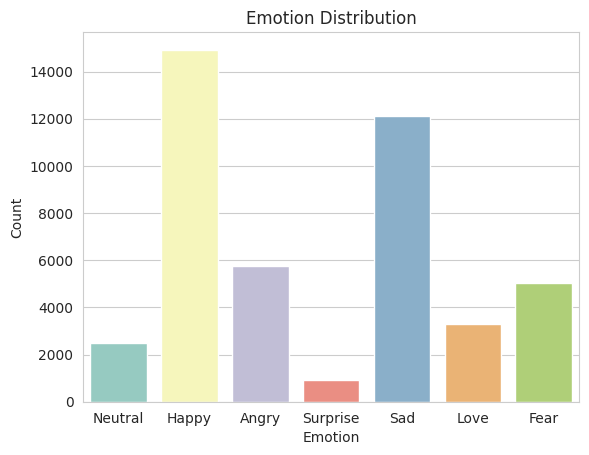

In [ ]:
# Create a countplot using Seaborn
sns.set_style("whitegrid")
sns.countplot(x = "Emotion",
              data = df,
              palette="Set3")

# Set chart title and labels
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")

# Show the chart
plt.show()

In [ ]:
df['Emotion'].value_counts()

Happy       14927
Sad         12108
Angry        5766
Fear         5025
Love         3282
Neutral      2505
Surprise      925
Name: Emotion, dtype: int64

**We see that close to 15,000 tweets are in the 'happy' category while there are roughly 12,000 tweets that are in the 'sad' category**

### Analysis of the tweet length and number of tokens per tweet after cleaning the text and removing stopwords

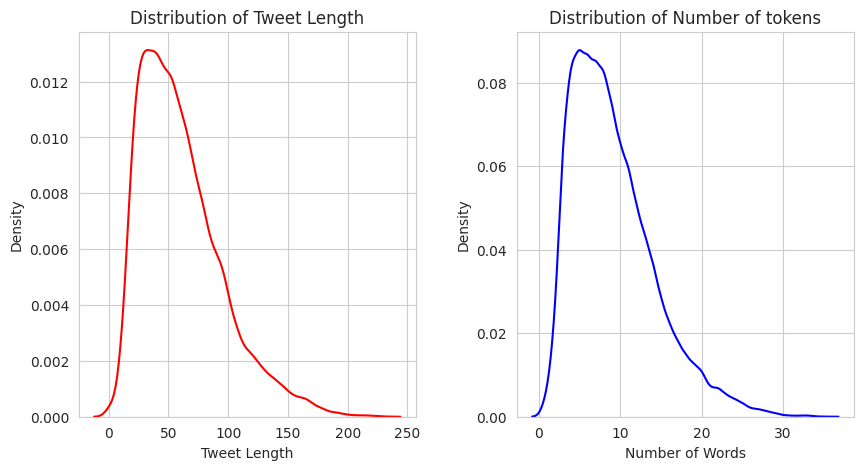

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Create a density plot for "tweet length" on the first subplot
sns.set_style("whitegrid")
sns.kdeplot(df['Text_clean_without_stopwords'].apply(lambda x : len(x)), ax=ax1, color="red")
ax1.set_title("Distribution of Tweet Length")
ax1.set_xlabel("Tweet Length")
ax1.set_ylabel("Density")

# Create a density plot for "number of tokens" on the second subplot
sns.set_style("whitegrid")
sns.kdeplot(df['Text_clean_without_stopwords'].apply(lambda x : len(x.split(" "))), ax=ax2, color="blue")
ax2.set_title("Distribution of Number of tokens")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Density")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

**Most of the tweets have a length of 25 - 100 characters and generally have a word count of 7-15 words**

### Analysis of the tweet length and number of tokens per tweet after cleaning the text and removing stopwords per Emotion

In [ ]:
new_df = df.copy()
new_df['tweet_length'] = new_df['Text_clean_without_stopwords'].apply(lambda x : len(x))
new_df['token_count'] = new_df['Text_clean_without_stopwords'].apply(lambda x : len(x.split(" ")))

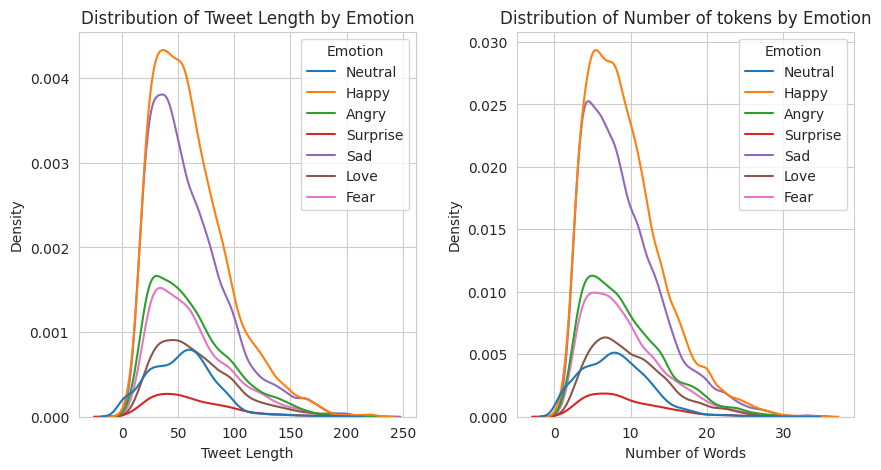

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Create a density plot for "tweet length" on the first subplot
sns.set_style("whitegrid")
sns.kdeplot(data = new_df , x = "tweet_length",  ax=ax1, hue = "Emotion")
ax1.set_title("Distribution of Tweet Length by Emotion")
ax1.set_xlabel("Tweet Length")
ax1.set_ylabel("Density")

# Create a density plot for "number of tokens" on the second subplot
sns.set_style("whitegrid")
sns.kdeplot(data = new_df , x = "token_count",  ax=ax2, hue = "Emotion")
ax2.set_title("Distribution of Number of tokens by Emotion")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Density")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

**We see that there is not much difference in the distribution for different emotions in both tweet length or the number of words in the tweet**

In [ ]:
new_df.head()

,Text,Emotion,Text_clean,Text_clean_without_stopwords,tweet_length,token_count
0,merci pour le partage!,Neutral,merci pour le partage,merci pour le partage,21,4
1,dorian gray with rainbow scarf #lovewins (from,Happy,dorian gray with rainbow scarf lovewins from,dorian gray rainbow scarf lovewins,34,5
2,... replace with your wish which the artist us...,Happy,replace with your wish which the artist uses i...,replace wish artist uses next installation ent...,53,7
3,thank you for following me back. great to hear...,Happy,thank you for following me back great to hear ...,thank following back great hear diverse & amp ...,83,11
4,what a beautiful jewel / portrait. is the 'r' ...,Happy,what a beautiful jewel portrait is the r for rex,beautiful jewel portrait r rex,30,5


### Creating Wordclouds for each Emotion

In [ ]:

def create_wordcloud(emotion):
  text = " ".join(review for review in new_df[new_df["Emotion"] == emotion].Text_clean_without_stopwords)

  wc = WordCloud(background_color="black",
                max_words=2000,
                stopwords= stop + ['feel','feeling','like'],
                contour_width=3)

  # generate word cloud
  print("Emotion is ", emotion)
  wc.generate(text)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

Emotion is  Neutral


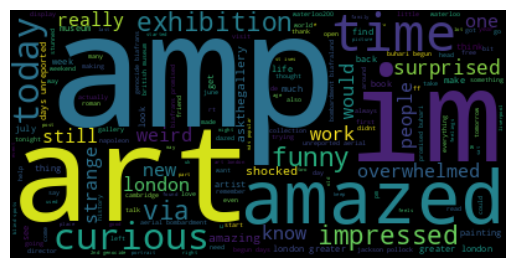

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[0])

Emotion is  Happy


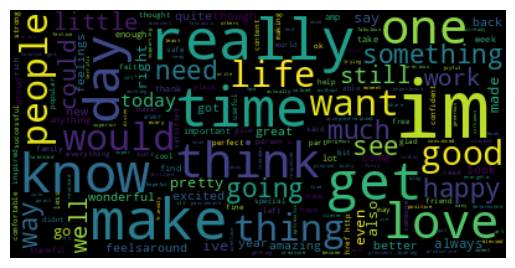

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[1])

Emotion is  Angry


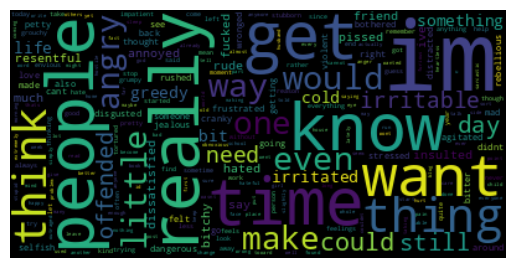

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[2])

Emotion is  Surprise


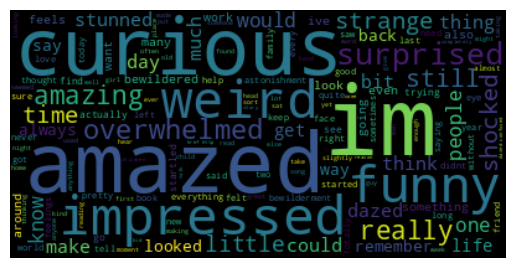

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[3])

Emotion is  Sad


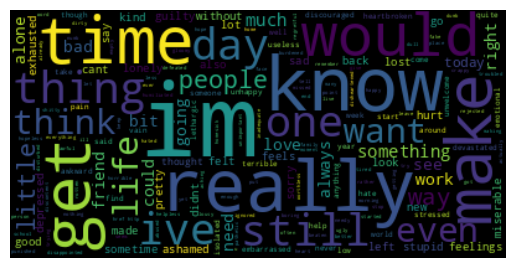

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[4])

Emotion is  Love


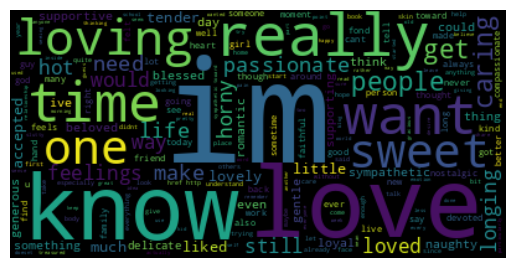

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[5])

Emotion is  Fear


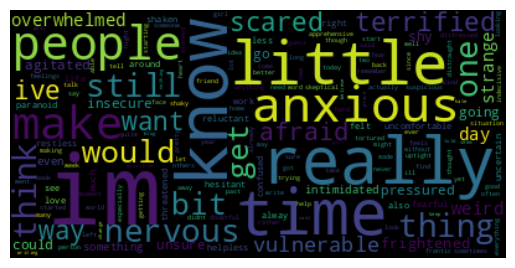

In [ ]:
create_wordcloud(new_df["Emotion"].unique()[6])

# **Model Building**

### Add this part at the End of the Modelling (add an audio file)

In [ ]:

# !apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
# !pip install PyAudio
# !pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyAudio-0.2.13.tar.gz (46 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyAudio: filename=PyAudio-0.2.13-cp39-cp39-linux_x86_64.whl size=68713 sha256=cf292323a80140eafc40e7170bea511f8e3b51e3906fd810b0dc039d90650b1a
  Stored in directory: /root/.cache/pip/wheels/d5/52/ae/fa7c92aa6e9f30fc009f4f5d7caf459fad3610f0a4022cf12a
Successfully built PyAudio


In [ ]:
import speech_recognition as sr

In [ ]:
# inp = sr.AudioFile('path/to/audio/file')
# with inp as file:
#   audio = r.record(file)